# TP 2 - Expectation-Maximization algorithm - Importance Sampling

The report associated to this notebook can be found [on GitHub](https://github.com/lmartinez2001/computational-statistics/blob/main/TD2/CompStat_TP2_report.pdf)

In [1]:
%matplotlib widget
import random
import numpy as np

from scipy.stats import poisson, multivariate_normal, norm

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd


from tqdm.notebook import tqdm

np.random.seed(0)
random.seed(0)


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

def plot_with_contours(X, z, mu, sigma, ax, title, xlabel='X', ylabel='Y', levels=15, min_level=1e-3, max_level=0.3, alpha_scatter=0.5, alpha_ellipse=0.3, xlim=None, ylim=None):
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 1000), 
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 1000))
    pos = np.dstack((x, y))
    levels = np.linspace(min_level, max_level, levels)
    
    ax.set_title(title)
    ax.scatter(X[:,0], X[:,1], c=z, alpha=alpha_scatter)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        ax.set_ylim(bottom=ylim[0], top=ylim[1])
    for m, s in zip(mu, sigma):
        rv = multivariate_normal(m, s)
        ax.contour(x, y, rv.pdf(pos), levels=levels, alpha=alpha_ellipse)

## Exercise 1 - Discrete distributions

### 2. Sampling algorithm

Here we implement the algorithm determined for Question 1. 

In [2]:
def sample_discrete(pdf, n_samples):
    """
    Samples n_samples samples from the probability density distribution pdf

    k is computed using binary search on the cdf.
    Ad the cdf is by definition an increasing array, we can apply binary search, ensuring a O(log n)) complexity (insteaf of O(n))
    """
    u = np.random.uniform(size=n_samples)
    cdf = pdf.cumsum() # integral of the pdf
    k = np.searchsorted(cdf, u, side='right') - 1 # binary search
    return k

### 3. Testing the implementation

To test our implementation, we to sample $(X_i)_{1\leq i \leq N}$ from a Poisson distribution with parameter $lambda$ (`lamb`).

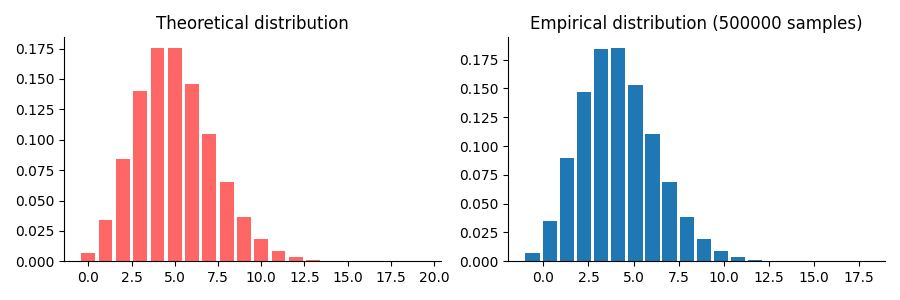

In [3]:
# We compute the poisson pdf on n points
N = 20
lamb = 5. # mean of the rv

x = np.arange(N)
pdf = poisson.pmf(x, lamb)

n_samples = 500_000
X = sample_discrete(pdf, n_samples)

fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].set_title('Theoretical distribution')
ax[0].bar(range(N), pdf, color='red', alpha=0.6)

ax[1].set_title(f'Empirical distribution ({n_samples} samples)')
ax[1].hist(X, density=True, bins=N, width=0.8)

plt.tight_layout()
plt.show()

## Exercise 2 - Gaussian mixture model and the EM algorithm

### 2. Sampling a Gaussian mixture

In [4]:
def sample_gaussian_mixture(n_samples, mu, sigma, alpha):
    z = sample_discrete(alpha, n_samples) # (n_samples,)
    means = mu[z] # (n_samples, d)
    covs = sigma[z] # (n_samples, d, d)
    
    X = np.array([np.random.multivariate_normal(mean, cov) for (mean, cov) in zip(means, covs)])
    
    return X, z


def sample_parameters(n_dim, n_clusters):
    mu = np.random.uniform(-10, 10, size=(n_clusters, n_dim))
    sigma = np.random.uniform(-2, 2, size=(n_clusters, n_dim, n_dim))
    sigma = sigma @ sigma.transpose(0,2,1)
    alpha = np.array(n_clusters * [1/n_clusters]) # Uniform distribution in each cluster by default
        
    return mu, sigma, alpha

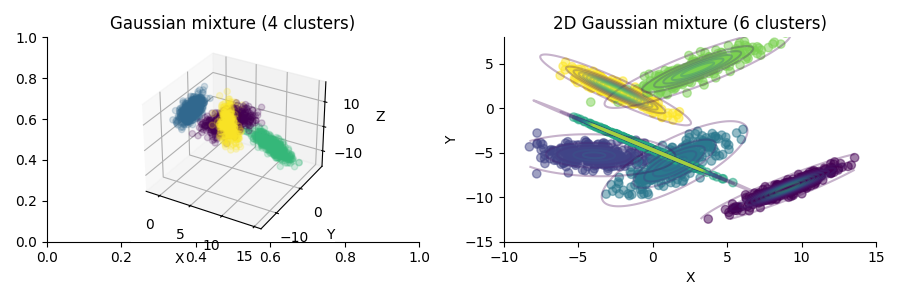

In [5]:
# 3D Gaussian mixture
n_samples_3d = 2000
n_clusters = 4
n_dim = 3
mu_3d, sigma_3d, alpha_3d = sample_parameters(n_dim, n_clusters)

X1, z1 = sample_gaussian_mixture(n_samples_3d, mu_3d, sigma_3d, alpha_3d)


# 2D Gaussian mixture
n_samples_2d = 2000
n_clusters_2d = 6
n_dim_2d = 2
mu_2d, sigma_2d, alpha_2d = sample_parameters(n_dim_2d, n_clusters_2d)

X2, z2 = sample_gaussian_mixture(n_samples_2d, mu_2d, sigma_2d, alpha_2d)


# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c=z1, alpha=0.2)
ax1.set_title(f'Gaussian mixture ({n_clusters} clusters)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plot_with_contours(
    X2, 
    z2, 
    mu_2d, 
    sigma_2d, 
    ax2, 
    f'2D Gaussian mixture ({n_clusters_2d} clusters)', 
    xlabel='X', 
    ylabel='Y', 
    levels=15,
    xlim=(-10,15),
    ylim=(-15,8)
)

plt.tight_layout()
plt.show()

### 3. Implementation of EM algorithm


The calculations used to determine the formulas for updating the parameters can be found in the report.

To simplify the expressions and the final implementation, we introduced $\gamma_{i j}^t$ in the following way

$$\gamma_{i j}^t = \frac{\alpha_j^t \phi_j^t (x_i)}{\sum_{k=1}^p \alpha_k^t \phi_k^t (x_i)}\hspace{2em}(i, j) \in [\![1,n]\!]\times[\![1,m]\!]$$

We can then derive the update formulas

$$\alpha_j^{t+1} = \frac{1}{n} \sum_{i=1}^n \gamma_{i j}^t$$

$$\mu_j^{k+1} = \frac{\sum_{i=1}^n \gamma_{i j}^t x_i}{\sum_{i=1}^n \gamma_{i j}^t}$$

$$\Sigma_j^{k+1}= \frac{\sum_{i=1}^n \gamma_{i j}^t (x_i-\mu_j)(x_i-\mu_j)^T}{\sum_{i=1}^n \gamma_{i j}^t}$$

In [6]:
def EM(X, n_clusters, max_iter=100):
    n_samples, n_dims = X.shape

    # Utility functions to initialize parameters
    def init_mu():
        init_indices = np.random.randint(n_samples, size=n_clusters)
        mu = X[init_indices] # Initialize means
        return mu

    def init_sigma():
        m = X.mean(axis=0) # (n_dims,)
        s2 = ((X-m)**2).mean() # (1,)
        sigma = np.zeros((n_clusters, n_dims, n_dims))
        for i in range(n_clusters):
            sigma[i] = (s2/n_clusters) * np.eye(n_dims)
        return sigma
    
    def init_alpha():
        alpha = np.ones(n_clusters) / n_clusters
        return alpha
    
    def compute_gamma(mu_t, sigma_t, alpha_t):
        gamma = np.zeros((n_samples, n_clusters))
        inv_sigma_t = np.linalg.inv(sigma_t + 1e-6 * np.eye(n_dims))
        for j in range(n_clusters):
            diff = X - mu_t[j][None,:]
            exponent = np.einsum('ij,jk,ik->i', diff, inv_sigma_t[j], diff)
            gamma[:,j] = (alpha_t[j] / np.sqrt(np.linalg.det(sigma_t[j]))) * np.exp(-0.5 * exponent) 
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma

    def compute_likelihood(mu_t, sigma_t, alpha_t):
        phi_t = np.zeros((n_samples, n_clusters)) # matrix of phi_j(x_i)
        inv_sigma_t = np.linalg.inv(sigma_t + 1e-6 * np.eye(n_dims))
        for j in range(n_clusters):
            diff = X - mu_t[j][None,:]
            exponent = np.einsum('ij,jk,ik->i', diff, inv_sigma_t[j], diff)
            phi_t[:,j] = (alpha_t[j] / np.sqrt(np.linalg.det(sigma_t[j]) * 2 * np.pi**n_dims)) * np.exp(-0.5 * exponent)
        likelihood = np.sum(np.log(phi_t.sum(axis=1)))
        return likelihood

    likelihoods = np.zeros(max_iter)
    mu = init_mu() # (n_clusters, n_dims)
    sigma = init_sigma() # (n_clusters, n_dims, n_dims)
    alpha = init_alpha() # (n_clusters,)

    # Running the algorithm
    for i in range(max_iter):
        # E step
        gamma = compute_gamma(mu, sigma, alpha) # (n_samples, n_clusters)
        c = gamma.sum(axis=0)

        # M step
        mu = (gamma[:,:,None] * X[:,None,:]).sum(axis=0) / c[:,None]
        alpha = c / n_samples
        centered_x = X[:,None,:] - mu[None,:,:] # (n_samples, n_clusters, n_dims)
        temp_mat = centered_x[...,:,None] * centered_x[...,None,:]
        sigma = (gamma[...,None,None] * temp_mat).sum(axis=0) / c[:,None,None]

        likelihoods[i] = compute_likelihood(mu, sigma, alpha)

    return mu, sigma, alpha, likelihoods


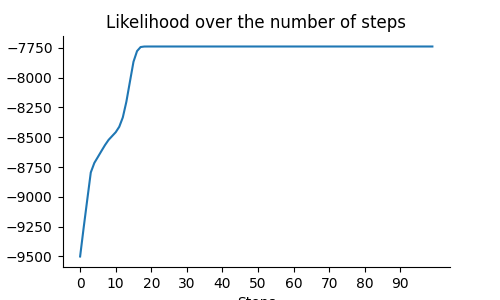

In [7]:
mu_pred, sigma_pred, alpha_pred, likelihoods_pred = EM(X2, n_clusters_2d)

plt.figure(figsize=(5,3))
plt.plot(likelihoods_pred)
plt.title('Likelihood over the number of steps')
plt.xlabel('Steps')
plt.ylabel('Likelohood')
plt.xticks(np.arange(0, len(likelihoods_pred), 10))
plt.show()

### 4. Analysis of the results

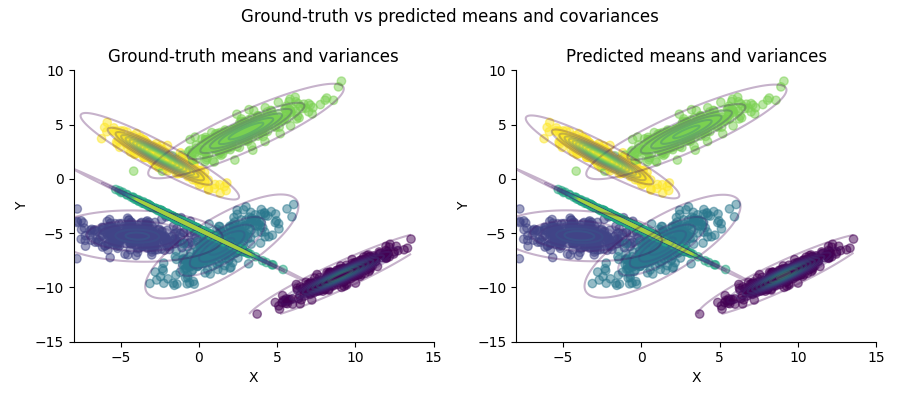

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle(f'Ground-truth vs predicted means and covariances')
plot_with_contours(
    X2, 
    z2, 
    mu_2d, 
    sigma_2d, 
    ax1, 
    'Ground-truth means and variances',
    xlim=(-8,15),
    ylim=(-15,10)
)

plot_with_contours(
    X2, 
    z2, 
    mu_pred, 
    sigma_pred, 
    ax2, 
    'Predicted means and variances',
    xlim=(-8,15),
    ylim=(-15,10)
)
plt.tight_layout()
plt.show()

In [9]:
print('Ground-truth means')
print("\n".join(f"({row[0]:.2f}, {row[1]:.2f})" for row in mu_2d))
print('\n')
print('Predicted means')
print("\n".join(f"({row[0]:.2f}, {row[1]:.2f})" for row in mu_pred))
print('\n\n')
print('Ground-truth cluster weights')
print("\n".join(f"{val:.3f}" for val in alpha_2d))
print('\n')
print('Predicted cluster weights')
print("\n".join(f"{val:.3f}" for val in alpha_pred))

Ground-truth means
(-3.93, -5.27)
(1.47, -6.22)
(-0.37, -4.41)
(3.01, 4.41)
(-2.49, 2.09)
(9.04, -8.93)


Predicted means
(-0.37, -4.40)
(9.08, -8.89)
(1.35, -6.20)
(2.88, 4.33)
(-2.48, 2.02)
(-3.95, -5.24)



Ground-truth cluster weights
0.167
0.167
0.167
0.167
0.167
0.167


Predicted cluster weights
0.163
0.167
0.160
0.161
0.194
0.155


### 5. Application 

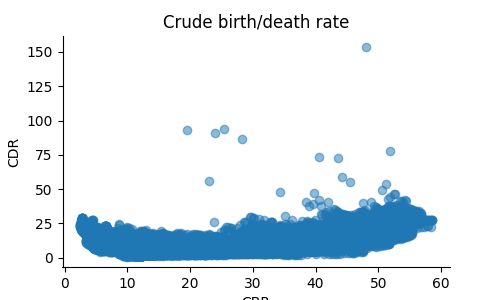

In [10]:
df = pd.read_csv('WPP2024_Demographic_Indicators_Medium.csv', low_memory=False)[['CBR', 'CDR']].dropna()
X = df.to_numpy()
n_samples, n_dims = X.shape

# Plottting the dataset
plt.figure(figsize=(5,3))
plt.title('Crude birth/death rate')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.xlabel('CBR')
plt.ylabel('CDR')
plt.show()

### 6. Finding the best number of clusters    

In [11]:
n_m = 6 # Number of values of m to try
max_iter = 60
all_mu = []
all_sigma = []
likelihoods = []

for m in range(1, n_m+1):
    mu, sigma, alpha, likelihood = EM(X, m, max_iter=max_iter)
    all_mu.append(mu)
    all_sigma.append(sigma)
    likelihoods.append(likelihood)

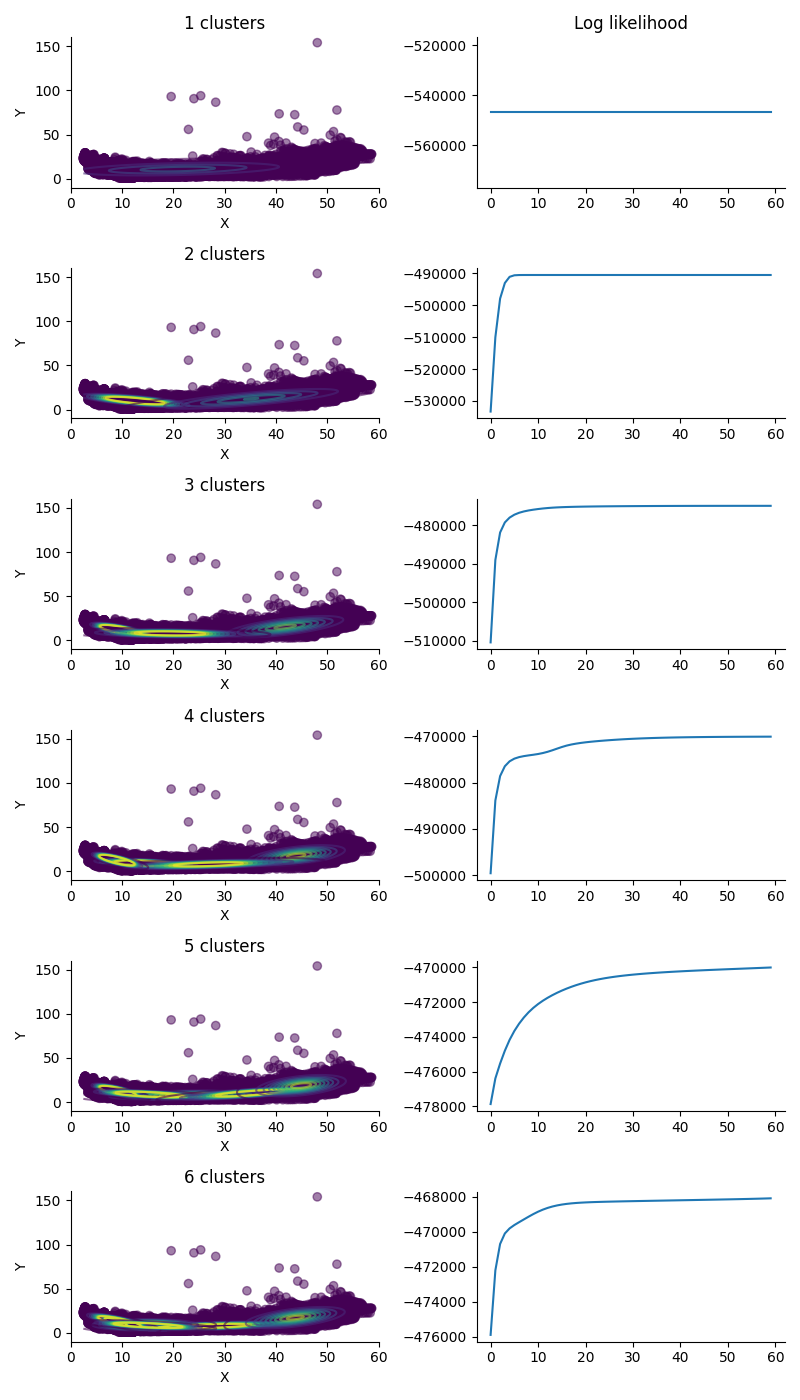

In [12]:
fig, ax = plt.subplots(n_m, 2, figsize=(8,14))
z = np.ones(n_samples)

ax[0][1].set_title('Log likelihood')
for m in range(n_m):    
    plot_with_contours(
        X, 
        z, 
        all_mu[m], 
        all_sigma[m], 
        ax[m][0], 
        f'{m+1} clusters', 
        xlabel='X', 
        ylabel='Y', 
        levels=10, 
        min_level=1e-4, 
        max_level=7e-3,
        xlim=(0, 60),
        ylim=(-10, 160),
        alpha_ellipse=0.6
    )
    ax[m][1].plot(likelihoods[m])
plt.tight_layout()
plt.show()

In [13]:
def BIC(n_samples, n_clusters, n_dims, likelihood):
    df = 0.5 * n_clusters * (n_dims + 1) * (n_dims+2) - 1
    return df * np.log(n_samples) - likelihood

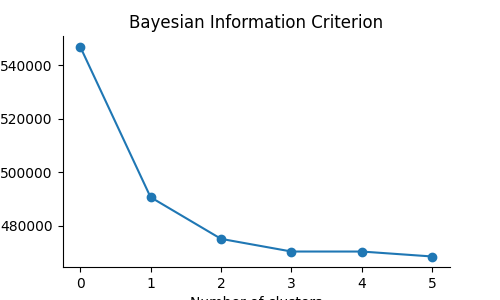

In [14]:
bics = [BIC(n_samples, m, n_dims, likelihood[-1]) for m, likelihood in zip(np.arange(n_m), likelihoods)]

plt.figure(figsize=(5,3))
plt.title('Bayesian Information Criterion')
plt.plot(bics, marker='o')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(n_m))
plt.show()

## Exercise 3 - Importance Sampling

## 3.A Poor Importance Sampling


We recall first the functions and variables at stake here.  
We want to calculate the expectation of a function $f$

$$\mathbb{E}_p [f(X)] = \int_x f(x) p(x) dx = \int_x f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_q \left[f(x)\frac{p(x)}{q(x)}\right]$$

with $f$ given by

$$f(x)=2  \sin\left(\frac{\pi}{1.5} x\right) \mathbb{1}_{\mathbb{R}^+}(x)$$

with $x$ distributed according to density $p$

$$p(x)=x^{(1.65)-1} e^{-\frac{x^2}{2}}\mathbb{1}_{\mathbb{R}^+}(x)$$

and $q$ given by 

$$q(x)=\frac{2}{\sqrt{2\pi (1.5)})} \exp\left(-\frac{(0.8-x)^2}{2(1.5)}\right)$$


In [15]:
def f(x):
    return 2 * np.sin(np.pi/1.5 * x) * (x>=0)


def p(x):
    return x**0.65 * np.exp(-0.5*x**2) * (x>=0)


def q(x, mean=0.8, var=1.5):
    return 2 * norm.pdf(x, loc=mean, scale=np.sqrt(var))

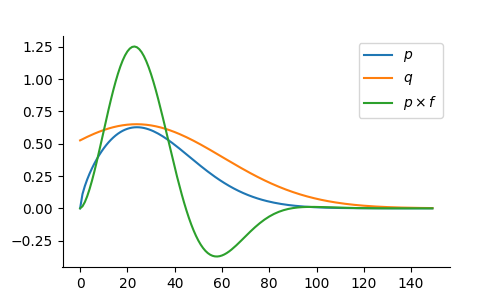

In [16]:
x = np.linspace(0, 5, 150)
plt.figure(figsize=(5,3))
plt.plot(p(x), label=r'$p$')
plt.plot(q(x), label=r'$q$')
plt.plot(p(x)*f(x), label=r'$p \times f$')
plt.legend()
plt.show()

### 1. Poor importance sampling implementation


_Note_: To make the sampling procedure faster, instead of looping until all the sampled values are positive, we sample 10 times more values than necessary and then filter them to keep only the positive ones. Finally, we only keep the needed number of values per sample.  
This method is a bet as nothing ensures we have enough values after filtering the negative ones. However the ratio is high enough for the issue not to occur.

In [17]:
def sample_q(size: tuple, mean=0.8, var=1.5):
    assert len(size) == 2
    n, p = size
    samples = 2 * norm(mean, np.sqrt(var)).rvs((n, p * 10))
    return np.array([row[row>0][:p] for row in samples])

def importance_weights(p, q):
    return p/q

def normalized_importance_weights(p_x ,q_x):
    assert p_x.ndim == 2 and q_x.ndim == 2
    weights = importance_weights(p_x, q_x) # (n, p)
    return weights / np.mean(weights, axis=1, keepdims=True) 

def poor_importance_sampling(f_x, p_x, q_x):
    weights = normalized_importance_weights(p_x, q_x)
    return np.mean(f_x * weights, axis=1)   

### 2. Mean and variance of the sampler

To compute the mean and the variance of the estimate, we repeat the experiment $n=500$ times for each sample size.

In [18]:
def plot_mean_var(means, varirances):
    """
    Utility function to plot mean and variance evolution with respect to the number of samples, in log scale
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    ax1.plot(N, means, marker='o')
    ax1.set_title('Means with respect to the number of samples')
    ax1.set_xlabel('Sample size')
    ax1.set_xscale('log')
    
    ax2.plot(N, variances, marker='o')
    ax2.set_title('Variances with respect to the number of samples')
    ax2.set_xlabel('Sample size')
    ax2.set_xscale('log')
    
    plt.tight_layout()
    plt.show()

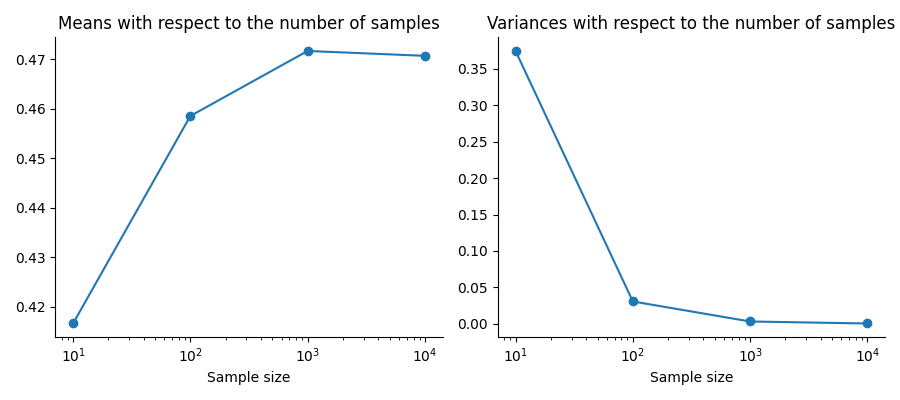

In [19]:
N = [10, 100, 1000, 10000]
n = 500

means = np.zeros(len(N))
variances = np.zeros(len(N))

for i, n_samples in enumerate(N):
    x = sample_q((n,n_samples)) # (n, n_samples)
    sampled = poor_importance_sampling(f(x), p(x), q(x)) # (n)
    means[i] = sampled.mean()
    variances[i] = sampled.var()

# Plotting results
plot_mean_var(means, variances)

### 3. Shifting $q$

As suggested in the subject we take $\mu=6$ for $q$.

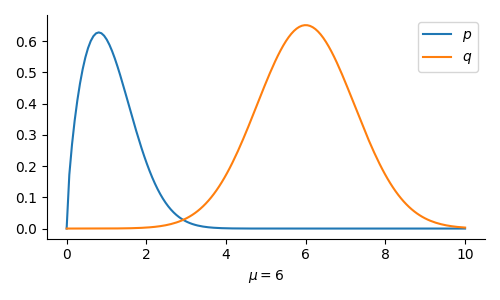

In [20]:
x = np.linspace(0, 10, 150)
plt.figure(figsize=(5,3))
plt.plot(x, p(x), label=r'$p$')
plt.plot(x, q(x, mean=6), label=r'$q$')
plt.xlabel(r'$\mu=6$')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.1 Mean and variance evolution for $\mu=6$

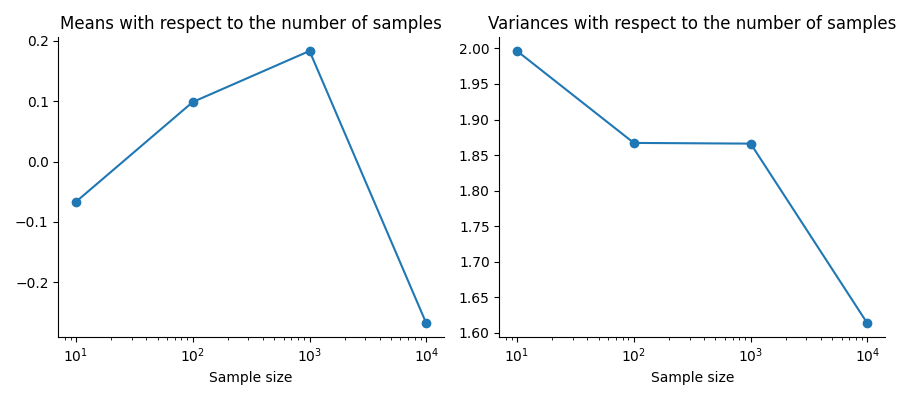

In [21]:
N = [10, 100, 1000, 10000]
n = 500
mean = 6

means = np.zeros(len(N))
variances = np.zeros(len(N))

for i, n_samples in enumerate(N):
    x = sample_q((n,n_samples), mean=mean) # (n, n_samples)
    sampled = poor_importance_sampling(f(x), p(x), q(x, mean=mean)) # (n)
    means[i] = sampled.mean()
    variances[i] = sampled.var()

# Plotting results
plot_mean_var(means, variances)

#### 3.2 Importance weights comparison

In [22]:
N = 1000
means = [0.8, 6]

weights = np.zeros((2, N))
x_vals = np.zeros_like(weights)

for i, mean in enumerate(means):
    x = sample_q((1, N), mean=mean)    
    weights[i] = importance_weights(p(x), q(x))
    x_vals[i] = x

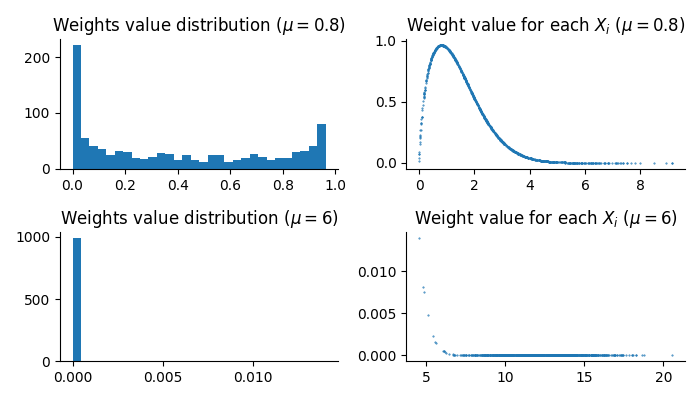

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(7,4))
for i, mean in enumerate(means):
    ax[i][0].hist(weights[i], bins=30)
    ax[i][0].set_title(rf'Weights value distribution ($\mu=${mean})')
    ax[i][1].scatter(x_vals[i], weights[i], s=.2)
    ax[i][1].set_title(rf'Weight value for each $X_i$ ($\mu=${mean})')
plt.tight_layout()
plt.show()

### 5. Adaptative Importance Sampling for a banana shaped density


As explained in question 4., Adaptative Importance Sampling boils down to the EM algorithm with different weights.

We replace

$$\gamma_{i j}^t = \frac{\alpha_j^t \phi_j^t (x_i)}{\sum_{k=1}^p \alpha_k^t \phi_k^t (x_i)}$$

Computed by the function `compute_gamma` in the code below

By 

$$\hat{\gamma}_{ij}^t=\omega_i^t \gamma_{i j}^t$$

denoted by `gamma_hat` in the function below

With


$$\omega_i^t=\frac{\frac{\nu(x_i)}{q(x_i)}}{\frac{1}{n} \sum_{j=1}^n \frac{\nu(x_j)}{q(x_j)}}$$

The computation is handled by the function `compute_omega`

Where $\nu$ is the target distribution. If $\phi$ denotes the pdf of a multivariate normal distribution in $\mathbb{R}^d$ with zero mean and covariance matrix $\Sigma= diag(\sigma_1^2, 1, ..., 1) \in \mathbb{R}^{d \times d}$, then

$$\forall x=(x_1,...,x_d), \nu(x) \propto \phi(x_1, x_2 + b(x_1^2-\sigma_1^2), x_3, ..., x_d)$$

$b, d, \sigma_1^2$ are hyperparameters of the distribution.

The current estimate $q_{\theta^t}$ of $\nu$ is a mixture of gaussians with $m$ clusters.

- At iteration $t$, we sample $(X_1^t, X_2^t, ..., X_n^t)$ iid from the current estimate of $\nu$ (denoted by $q$ in the function below).
- We then estimate the next set of parameters using the formulas derived in the report.

In [24]:
def adaptive_importance_sampling(n_clusters, n_samples, n_dims, sigma2, b, max_iter=40):

    sigma_target = np.eye(n_dims)
    sigma_target[0,0] = sigma2
    inv_sigma_target = np.linalg.inv(sigma_target)
    det_sigma_target = np.linalg.det(sigma_target)

    def target_pdf(X):
        """
        Computes the output value of the pdf of nu applied to every line of X
        Note that the pre-exponential term could be computed once as it's constant.
        We therefore keep it here as it's not computanionally expensive and it improves the clarity of the code
        """
        exponent = np.einsum('ij,jk,ik->i', X, inv_sigma_target, X)
        res = 1 / np.sqrt(det_sigma_target) * np.exp(-0.5 * exponent)
        return res

    def current_pdf(X, mu_t, sigma_t, alpha_t):
        """
        Computes the output value of the pdf of the current estimate of the distribution nu
        """
        pdf = np.zeros((n_samples, n_clusters))
        inv_sigma_t = np.linalg.inv(sigma_t + 1e-6 * np.eye(n_dims))
        for j in range(n_clusters):
            diff = X - mu_t[j][None,:]
            exponent = np.einsum('ij,jk,ik->i', diff, inv_sigma_t[j], diff)
            pdf[:,j] = (alpha_t[j] / np.sqrt(np.linalg.det(sigma_t[j]) + 1e-6)) * np.exp(-0.5 * exponent) # (n_samples, n_clusters)
        return pdf # (n_samples, n_clusters)

    def compute_gamma(X, mu_t, sigma_t, alpha_t):
        gamma = current_pdf(X, mu_t, sigma_t, alpha_t) # (n_samples, n_clusters)
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma
    
    def compute_omega(nu_t, q_t):
        ratio = nu_t / (q_t + 1e-8) 
        return ratio / (ratio.mean() + 1e-8) # (n_samples,)
        
    mu = np.random.randn(n_clusters, n_dims) # (n_clusters, n_dims)
    sigma = np.zeros((n_clusters, n_dims, n_dims)) + np.eye(n_dims) # (n_clusters, n_dims, n_dims)
    alpha = np.ones(n_clusters) / n_clusters # (n_clusters,)

    # Running the algorithm
    for i in range(max_iter):
        # Sampling from current distribution
        X, _ = sample_gaussian_mixture(n_samples, mu, sigma, alpha) # (n_samples, n_dims)
        transformed_X = X.copy()
        transformed_X[:,1] += b * (transformed_X[:,0]**2 - sigma2**2) # (n_samples, n_dims)
        
        # E step
        nu = target_pdf(transformed_X) # (n_samples,)
        q = current_pdf(X, mu, sigma, alpha).sum(axis=1) # (n_samples,)
        omega = compute_omega(nu, q) # (n_samples,)
        gamma = compute_gamma(X, mu, sigma, alpha) # (n_samples, n_clusters)
        gamma_hat = omega[:,None] * gamma # (n_samples, n_clusters)
        c = gamma_hat.sum(axis=0) # (n_clusters,)
        
        # M step
        mu = (gamma_hat[:,:,None] * X[:,None,:]).sum(axis=0) / c[:,None]
        alpha = c / n_samples
        centered_x = X[:,None,:] - mu[None,:,:] # (n_samples, n_clusters, n_dims)
        temp_mat = centered_x[...,:,None] * centered_x[...,None,:]
        sigma = (gamma_hat[...,None,None] * temp_mat).sum(axis=0) / c[:,None,None]

    return mu, sigma, alpha


#### 5.1 Running the algorithm

In [25]:
n_clusters = 5
n_samples = 2000
n_dims = 5
sigma2 = 1.0
b = 1.0
max_iter = 60

mu, sigma, alpha = adaptive_importance_sampling(n_clusters, n_samples, n_dims, sigma2, b, max_iter)
X, z = sample_gaussian_mixture(n_samples, mu, sigma, alpha)

#### 5.2 Plotting the results

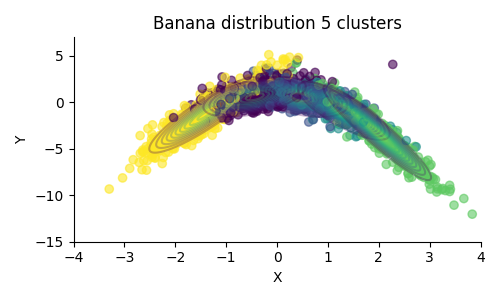

In [27]:
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plot_with_contours(
    X[:,:2], 
    z, 
    mu[:,:2], 
    sigma[:,:2,:2], 
    ax, 
    f'Banana distribution {n_clusters} clusters', 
    min_level=5e-2, 
    max_level=0.4, 
    alpha_ellipse=0.3,
    alpha_scatter=0.6,
    ylim=(-15, 7),
    xlim=(-4, 4)
)
plt.tight_layout()
plt.show()